In [1]:
# All the necesssary imports.
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.core import Activation, Dropout
from keras.layers import LeakyReLU
from keras import initializers
from keras.datasets import mnist
from keras.optimizers import Adam, RMSprop, SGD
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# Load in the data.
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Normalize to [-1, 1] (easier to work with)
x_train = (x_train.astype(np.float32) - 127.5) / 127.5

# For the sake of time don't work with the entire dataset.
x_train = x_train[:10000]
y_train = x_train[:10000]

# Flatten the data.
x_train = x_train.reshape((-1, 784))
x_test = x_test.reshape((-1, 784))

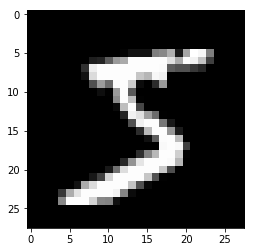

In [3]:
# Plot out a sample image (reshaped to 28 x 28)
plt.imshow(x_train[0].reshape(28, 28), cmap=plt.get_cmap('gray'))
plt.show()

In [49]:
# How many noise dimensions our generator should take in
NOISE_DIM = 100 # Feel free to tweak this and see what changes

# Define the generator.
# The generator should have the following layers.
# Fully connected from # noise dimensions to 256
# LeakyReLU (alpha = 0.2) (what is leaky relu? https://cdn-images-1.medium.com/max/1600/1*A_Bzn0CjUgOXtPCJKnKLqA.jpeg)
# Fully connected from 256 to 512
# LeakyReLU (alpha = 0.2)
# Fully connected from 512 to 1024
# LeakyReLU (alpha = 0.2)
# Fully connected from 1024 to 784 (28*28)
# tanh (To normalize our output from -1 to 1)

def generator():
    ###################################
    #TODO: Implement
    model = Sequential()
    
    # How to add leaky relu
    #model.add(LeakyReLU())
    # (We'll give you this first layer. Keep the initializer as is -- it works better than the default)
    # (You can also keep initializers default for the rest of the layers)
    model.add(Dense(256, input_dim=NOISE_DIM, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
   
    # Add the rest of the layers
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Dense(512, input_dim=256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1024, input_dim=512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(784, input_dim=1024))
    
    return model
    ###################################

In [50]:
# Define the discriminator here.
# Should have the following layers
# Fully connected from 784 (28*28) to 1024
# LeakyReLU (alpha = 0.2)
# Dropout with p = 0.3
# Fully connected from 1024 to 512
# LeakyReLU (alpha = 0.2)
# Dropout with p = 0.3
# Fully connected from 512 to 256
# LeakyReLU (alpha = 0.2)
# Dropout with p = 0.3
# Fully connected from 256 to 1
# sigmoid (to get our probability)

def discriminator():
    model = Sequential()
    # (We'll give you this first layer. Keep the initializer as is -- it works better than the default)
    model.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    
    # Add the rest of the layers
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))
    model.add(Dense(512, input_dim=1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))
    model.add(Dense(256, input_dim=512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))
    model.add(Dense(1, input_dim=256))
    model.add(Activation('sigmoid'))
    
    return model
    ###################################

In [51]:
# Feed the generated image into the discriminator. 
# We’ll use this to train our generator end-to-end later on, 
    # while leaving the discriminator weights untouched 
# Hint: we can add existing Sequential() models to new models, just like we can with any other layer.
    # The parameters are then "passed by reference," so that they use the same internal weights.

# Remember that we are not updating our discriminator in this step. 
    # (We'll train the discriminator separately.)
# Please refer to 
    # https://keras.io/getting-started/faq/#how-can-i-freeze-keras-layers
    # on how to "freeze" or set layers to be untrainable in keras.
# We can call this "freeze" operation on an entire model.

def combine(generator, discriminator):
    ###################################
    # TODO: Implement
    #for layer in discriminator.layers:
     #   layer.trainable=False
    discriminator.trainable=False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model
    ###################################

In [74]:
# Compile the discriminator, generator, and full GAN. 

# Use this optimizer for each of the models
opt = Adam(lr=.0002, beta_1=0.5)

#############################################
# TODO: Compile generator and discriminator
g = generator()
# generator.compile(optimizer=opt, loss='categorical_crossentropy')
# Discriminator
# d = None
d = discriminator()
d.compile(optimizer=opt, loss='categorical_crossentropy')
# Full gan
# gd = None
gan = combine(g, d)
gan.compile(optimizer=opt, loss='categorical_crossentropy')
#############################################

In [75]:
# Helper function to display sample from the network
def disp_sample(g):
    noise = np.random.uniform(-1, 1, size=(batch_size, NOISE_DIM))
    generated_images = g.predict(noise, verbose=0)
    show_im = generated_images[0]
    show_im = (show_im + 1) / 2.0
    show_im = show_im.reshape(28, 28)
    plt.imshow(show_im, cmap='gray')
    plt.show()

Epoch #0


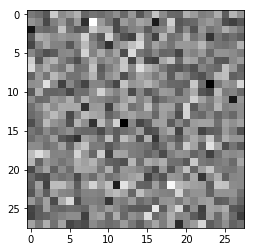

ValueError: You are passing a target array of shape (256, 1) while using as loss `categorical_crossentropy`. `categorical_crossentropy` expects targets to be binary matrices (1s and 0s) of shape (samples, classes). If your targets are integer classes, you can convert them to the expected format via:
```
from keras.utils import to_categorical
y_binary = to_categorical(y_int)
```

Alternatively, you can use the loss function `sparse_categorical_crossentropy` instead, which does expect integer targets.

In [78]:
# Keep this. 
batch_size = 128

for epoch in range(100):
    print('Epoch #%d' % epoch)
    
    # Generate an image and display it.
    disp_sample(g)
    
    num_batches = int(x_train.shape[0] / batch_size)
    all_g_loss = []
    all_d_loss = []
    for i in range(num_batches):
        #######################################################
        #TODO: Complete a training iteration
        # Generate noise.
        noise = np.random.uniform(-1, 1, size=(batch_size, NOISE_DIM))
        
        # Generate images from the noise using the generator.
            # See 'predict()': https://keras.io/models/sequential/
        generated_images = _generator.predict(noise)
        
        # Grab the image batch for this iteration. 
        real_images = x_train[i * batch_size: (i+1) * batch_size]
        
        ### Train the discriminator using the generated images and the real images ###
        
        # Contains the real and fake images. (Concatenate!)
            # https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.concatenate.html
        X = np.concatenate((generated_images, real_images))
        
        # Labels if the sample is real (1) or not real (0). 
            # Numpy 'ones' function: https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ones.html
            # 'zeros': https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.zeros.html
        y = np.ones((batch_size * 2))
        
        # Remember that for this line, the discriminator has to have d.trainable = True!
            # Update d.trainable as necessary
        d.trainable = True
        d_loss = d.train_on_batch(X, y)
        # Now, set d.trainable to False again to get ready for the end-to-end generator training
            # (We want to hold the discriminator constant while we're training the generator. See below.)
        d.trainable = False
        # Generate more noise to feed into the full gan network to train the generative portion. 
        noise = noise = np.random.uniform(-1, 1, size=(batch_size, NOISE_DIM))

        
        # Get the g_loss (fill in the ... part between the parantheses)
            # Hint: we want the final output to be 1 (indicating that the discriminator was fooled),
            # So the labels should be all 1's. 
            # Then, since the discriminator weights are fixed,
            # the generator weights will have to adjust so that the final outputs will be closer to 1 
            # (i.e. are are producing more realistic images).
        g_loss = dg.train_on_batch(...)
        
        # For getting the averages of each epoch
        all_d_loss.append(d_loss)
        all_g_loss.append(g_loss)
        
        #######################################################
    print('%i D: %.4f, G: %.4f' % (epoch, np.mean(all_d_loss), np.mean(all_g_loss)))

#########################################################################################
# Why is my generative loss oscillating???   
# Don't worry this is normal as the generator is oscillating between possible solutions
#########################################################################################
        